# Code for Batch Trajectory Alignment and Similarity Metrics

In [1]:
# Set up:
# %matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook

import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from ipywidgets import *

mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

# import plotly.graph_objects as go
# import plotly.express as px
# import ipywidgets as widget

# Computation packages
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks
from fastdtw import fastdtw

In [2]:
from nah.loader import load_raw_csv_data, load_npzs
from nah.utils import norm_data, full_align,clean_rot_data, segment_by_demo, sum_of_squares, study_range_vals, cluster, organize_cluster_graph
from nah.plot import plot_norm, plot_pos, plot_rot, plot_raw_data, plot_heatmap, plot_correlation_matrix, plot_clusters
from nah.datagraphs import generate_self_similarity_heat_map, hand_range, study_range_vals, generate_all_cross_correlation_matrix, generate_pairwise_comparison, generate_hand_endeff_similarity_matrix

from evo.core.trajectory import PoseTrajectory3D
from nah.trajectory import get_evo_trajectory, get_evo_metrics, evo_sync, convert_evo_to_np, evaluate_ape
from nah.alignments import evo_align, Alignment

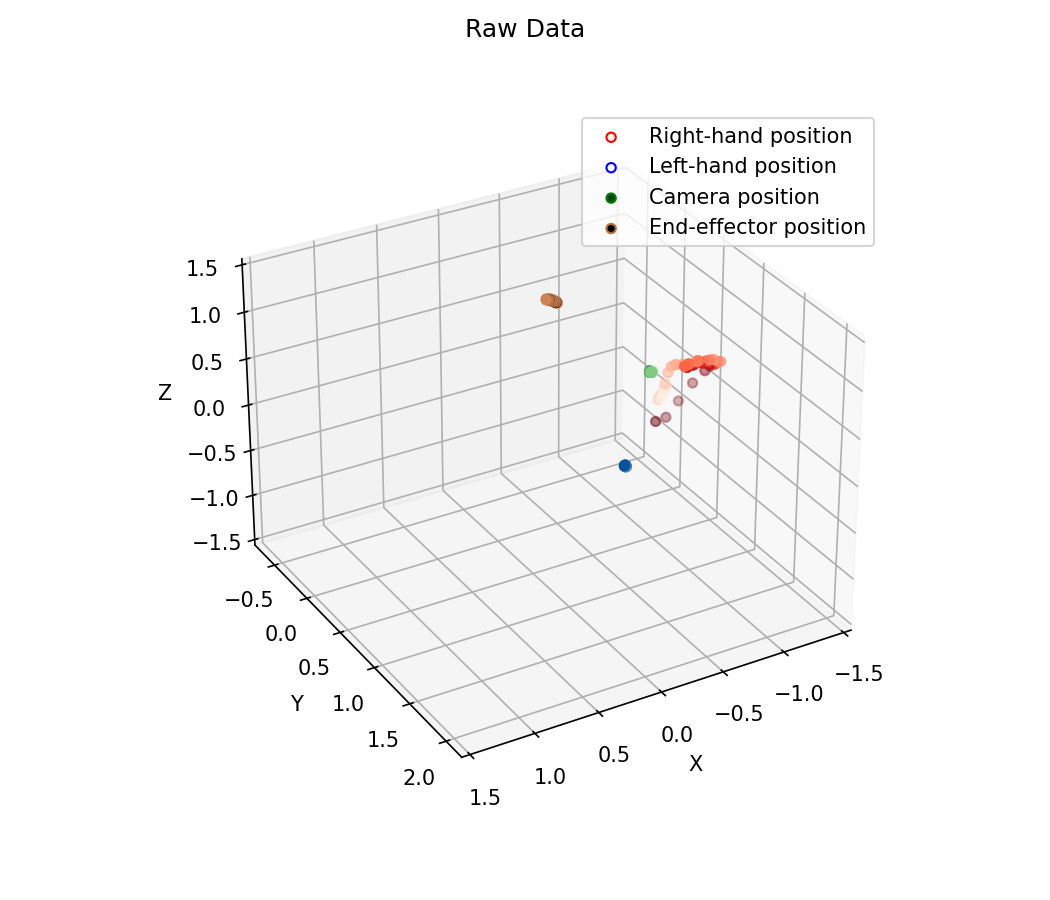

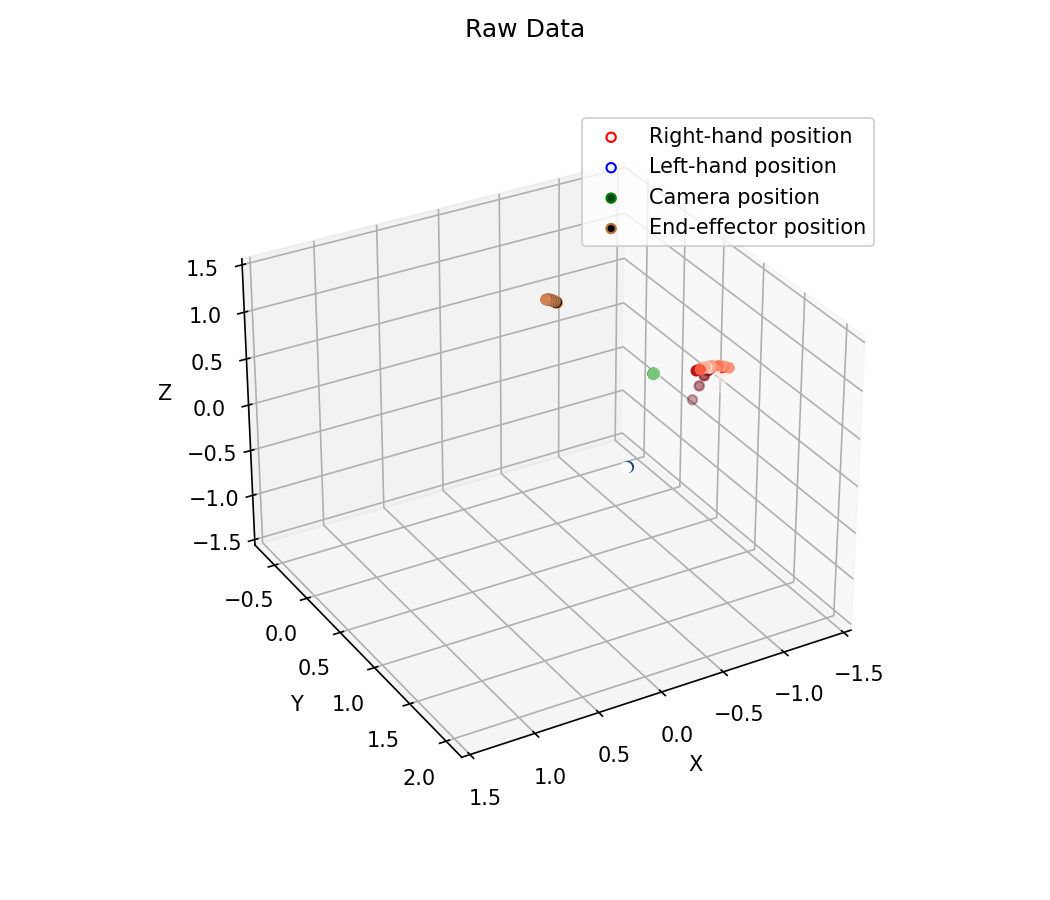

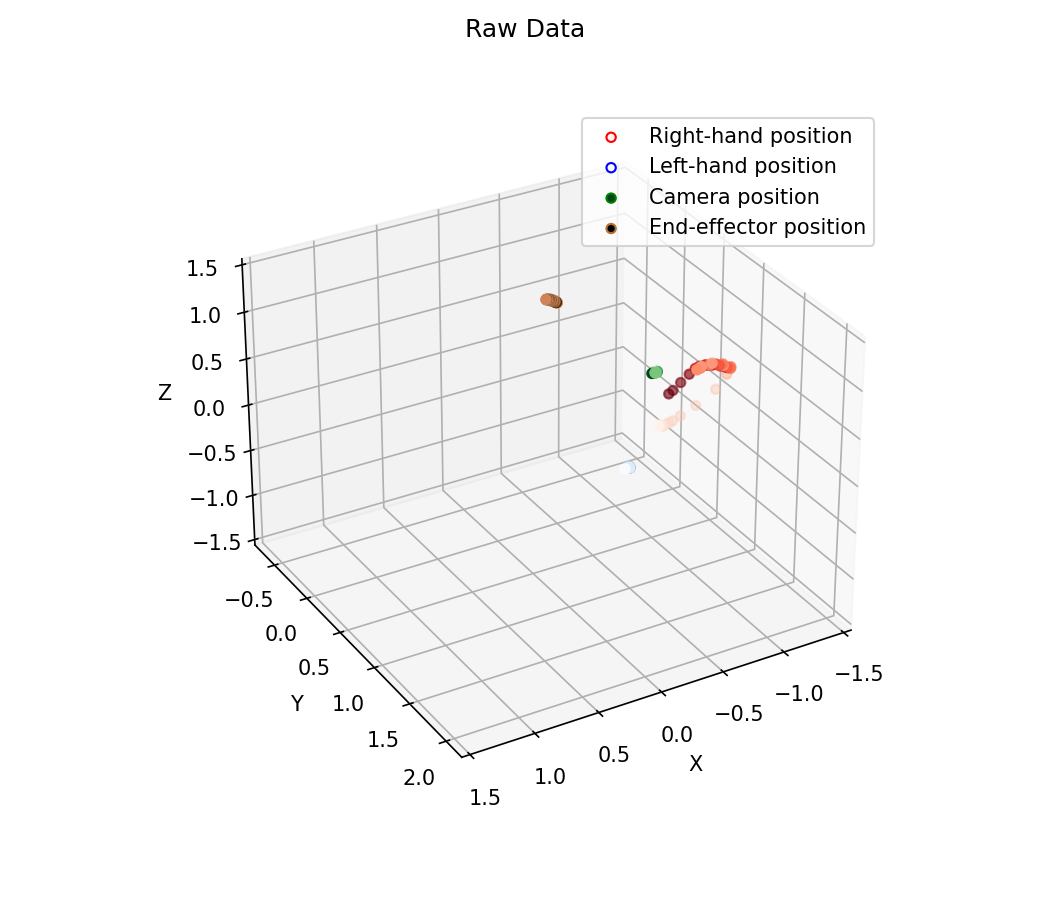

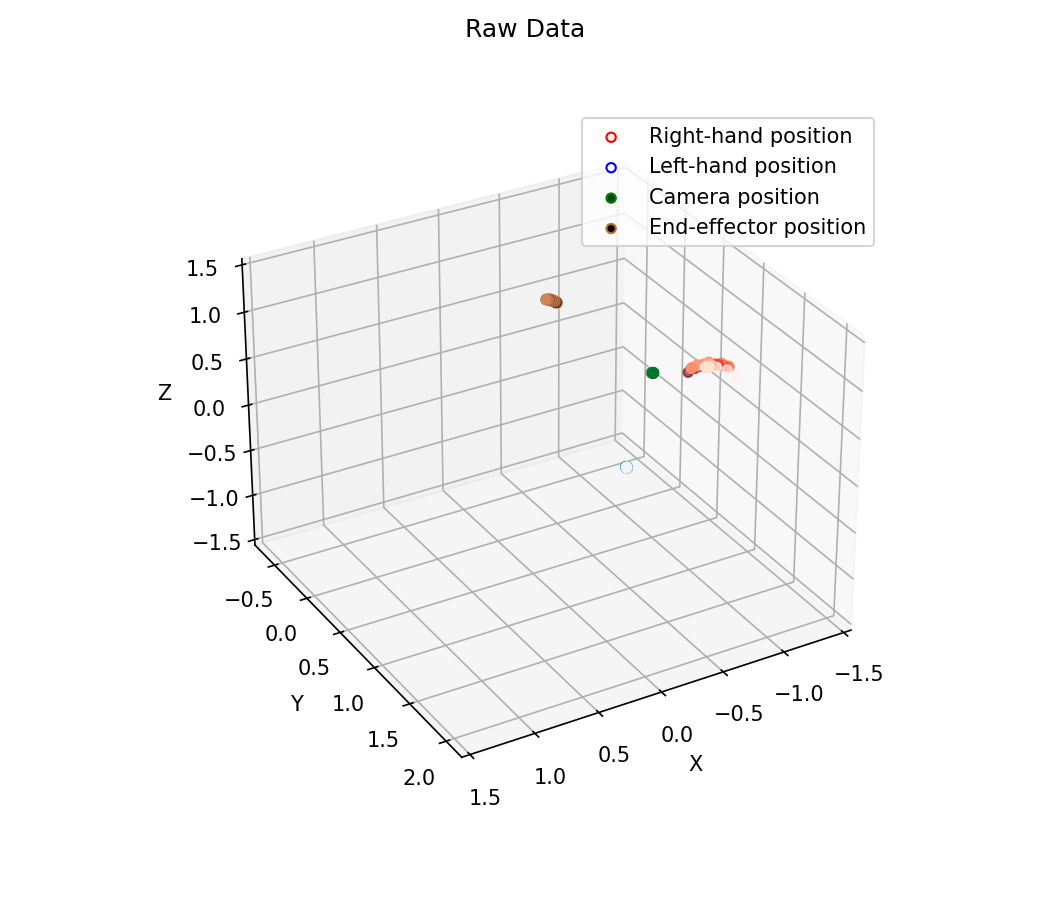

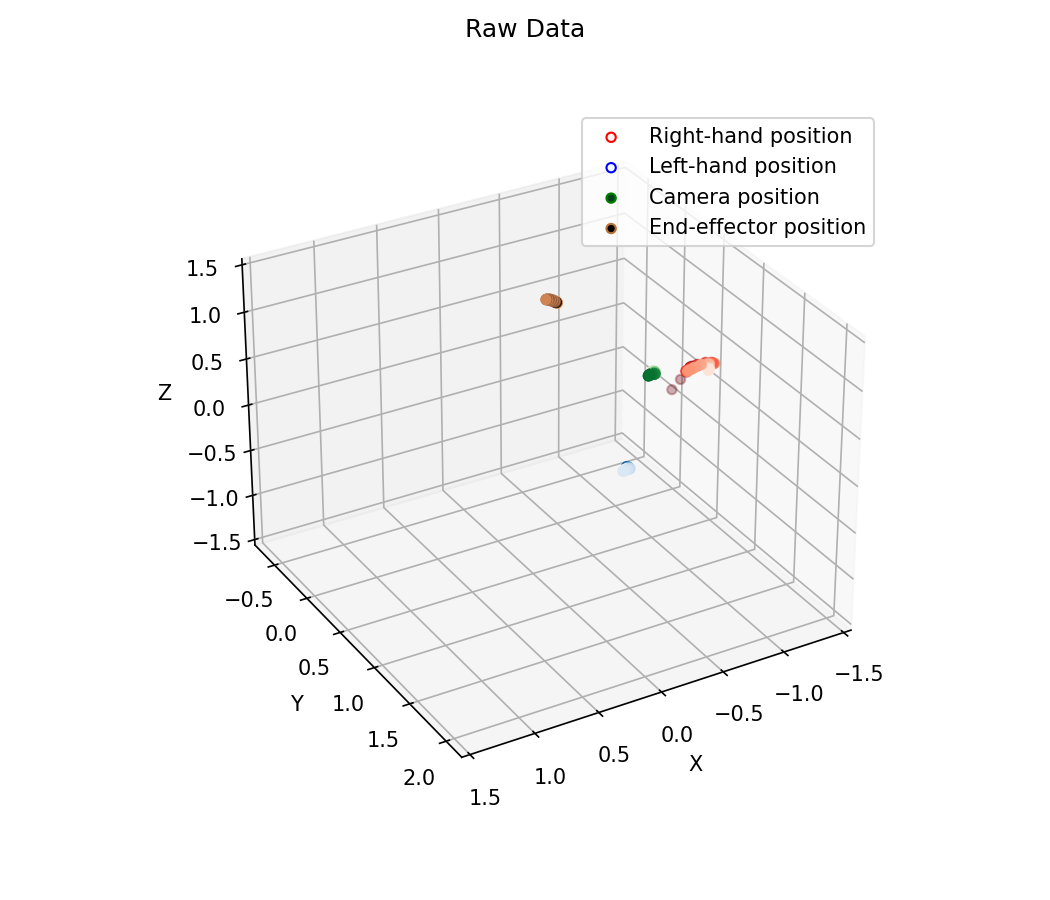

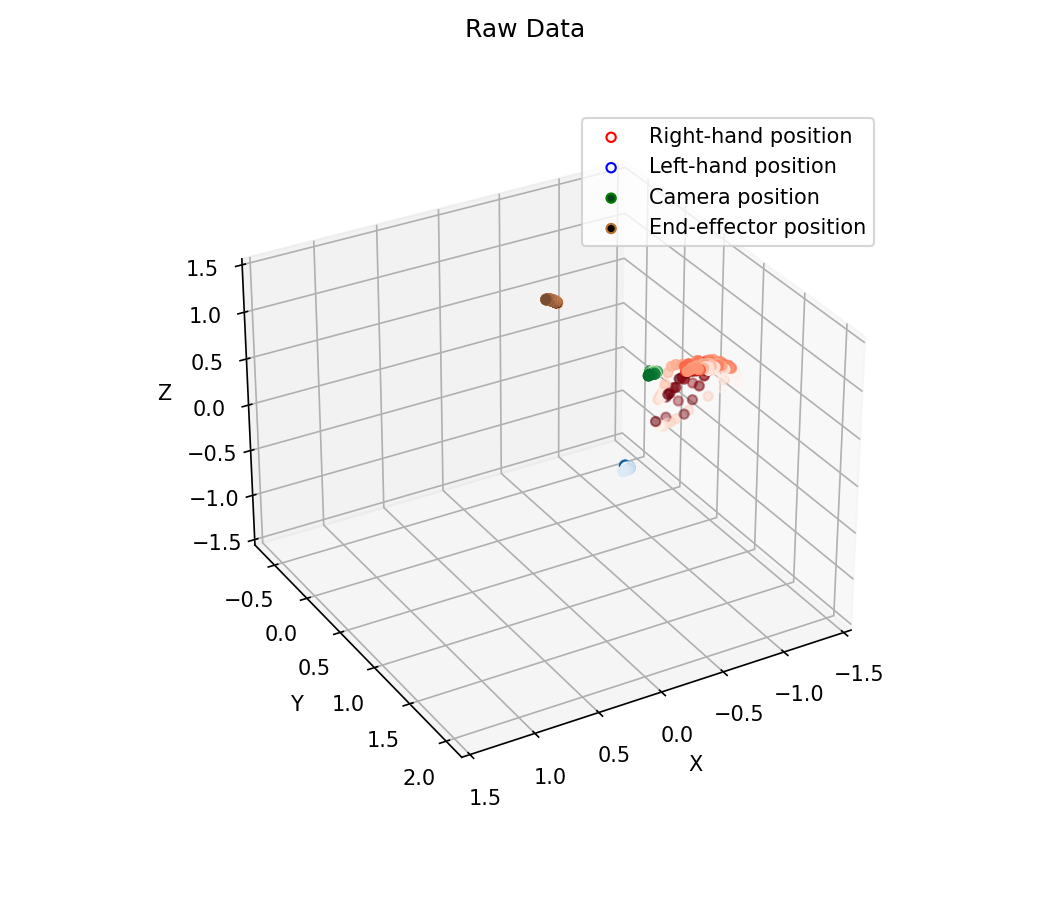

In [14]:
%matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook

# robot_name='j2s6s300'
robot_name='Reachy'
gesture_num=1


total_end_eff = np.array([])
total_camera  = np.array([])
total_rh      = np.array([])
total_lh      = np.array([])
total_joint   = np.array([])

singlePID=True
singlePIDval = 7
followup = True

if singlePID:
    PID_begin_range=singlePIDval
    PID_end_range=singlePIDval+1 #Don't forget to +1 to whatever your last PID is
else:
    PID_begin_range=1
    if followup:
        PID_end_range=10 #Don't forget to +1 to whatever your last PID is
    else:
        PID_end_range=17
for PID in range(PID_begin_range,PID_end_range):
    end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)
    if (PID==PID_begin_range):
        total_end_eff = end_eff
        total_camera = camera
        total_rh = rh
        total_lh = lh
        total_joint = joint
    else:
        total_end_eff = np.vstack((total_end_eff,end_eff))
        total_camera  = np.vstack((total_camera,camera))
        total_rh      = np.vstack((total_rh,rh))
        total_lh      = np.vstack((total_lh,lh))
        total_joint   = np.vstack((total_joint,joint))

# plot_raw_data(5, total_end_eff, total_camera, total_rh, total_lh, total_joint)

demo_max=5
end_eff, camera, rh, lh, joints = segment_by_demo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
for i in range(0,5):
    plot_raw_data(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])

plot_raw_data(5, total_end_eff, total_camera, total_rh, total_lh, total_joint)

Right hand range:0.8500059763056297
Left hand range:0.08426110137044254
Camera range:0.048635552726374875
Right hand range:0.8088668657341824
Left hand range:0.09001172821166141
Camera range:0.034044721206084254
Right hand range:0.6369223608824233
Left hand range:0.09896899522224113
Camera range:0.029836401647148993
Right hand range:0.19759494479221884
Left hand range:0.06139179344676292
Camera range:0.024984873511987287
Right hand range:0.29726533649453657
Left hand range:0.07473482293924287
Camera range:0.0946723129560063
Centering data for participant 1 gesture 5
Centering data for participant 1 gesture 5
Right hand range:0.2659537621302808
Left hand range:0.12102093982683321
Camera range:0.030399003058653035
Right hand range:0.6693348848224556
Left hand range:0.08578410018534897
Camera range:0.05569409910897202
Right hand range:0.8915826918624579
Left hand range:0.08844392605854853
Camera range:0.0653856261497892
Right hand range:0.9845629214902876
Left hand range:0.194671717146816

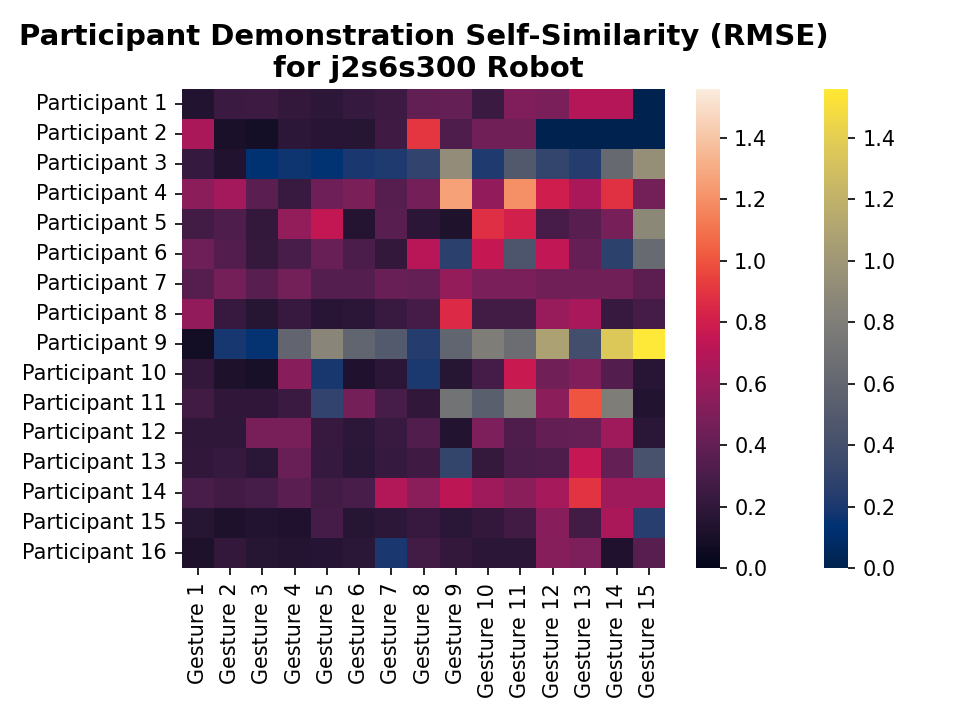

In [19]:
plt.close("all")

robot_name = "j2s6s300"
# robot_name = "Reachy"

followup = False
demo_max = 5

demo_heatmap_array, handed_array = generate_self_similarity_heat_map(robot_name,followup, demo_max)
plt.close("all")
plot_heatmap(robot_name, followup, demo_heatmap_array, handed_array, self=True)


In [3]:
"""Cross-correlation matrix:

Generate one cross-correlation graph per gesture, per robot, comparing all participants to each other.
Each participant does 5 demos, so that means 5x5 pairwise demo comparisons. Average the RMSE (should 
be legitimate; the lengths of the trajectories are almost the same). Each pairwise comparison of demos 
needs to be both temporally and spatially aligned. (Other analyses with only temporal or only spatial
alignment are also interesting, showing where participants chose similar motions with different rates
of speed, or similar motions but with different levels of enthusiasm. But for now, do all of it. The
order of operations is as follows:

1) For each robot and gesture, load two participants (go through all pairs)
2) For each pair, go through all pairs of demos
3) Figure out which hand is being used. Compare only the active hands. Make a matrix of which hand is
   being used so that we can color-code this in the final plot.
4) For that hand (for each participant), align the trajectories, first spatially (with evo), then 
   temporally (with DTW)
5) Compute the similarity between demos with APE (perhaps with translation scaling, or translation 
    only?)
6) Save this into the appropriate entry in a matrix so this can be turned into a heat map with seaborn
"""
# robot_name = "j2s6s300"
robot_name = "Reachy"
followup=False
demo_max = 5
gesture = 1
participant_1 = 12
participant_2 = 13

temp_metric, is_right_hand = generate_pairwise_comparison(participant_1, participant_2,robot_name, gesture, followup, demo_max, alignment=Alignment.Spatial)
# correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max)
# plot_heatmap(robot_name, followup, correlation_array, hand_array)                
print(temp_metric)
print(is_right_hand)


0.6823602273452946
True


Getting metrics for Participants 1 and 1: 
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Unable to compare participants 1 demo 1 and 1 demo 5
Gesture 15: Failed to get metrics for participant 1 demo 2, 1 demo 5.
 Ret

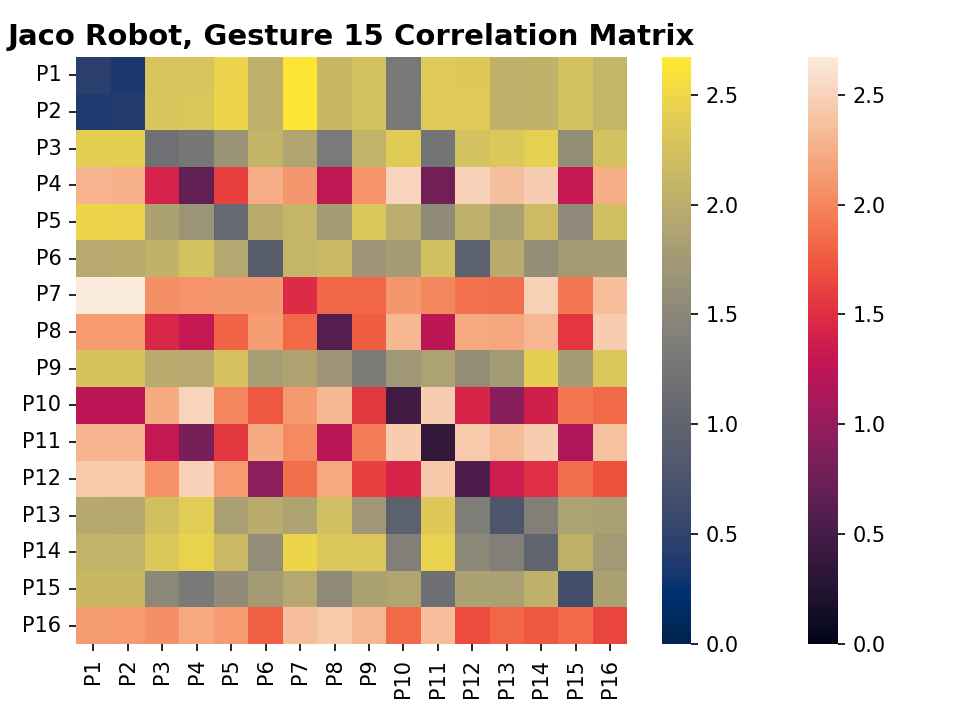

Getting metrics for Participants 1 and 1: 
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Unable to compare participants 1 demo 1 and 1 demo 5
Gesture 15: Failed to get metrics for participant 1 demo 2, 1 demo 5.
 Ret

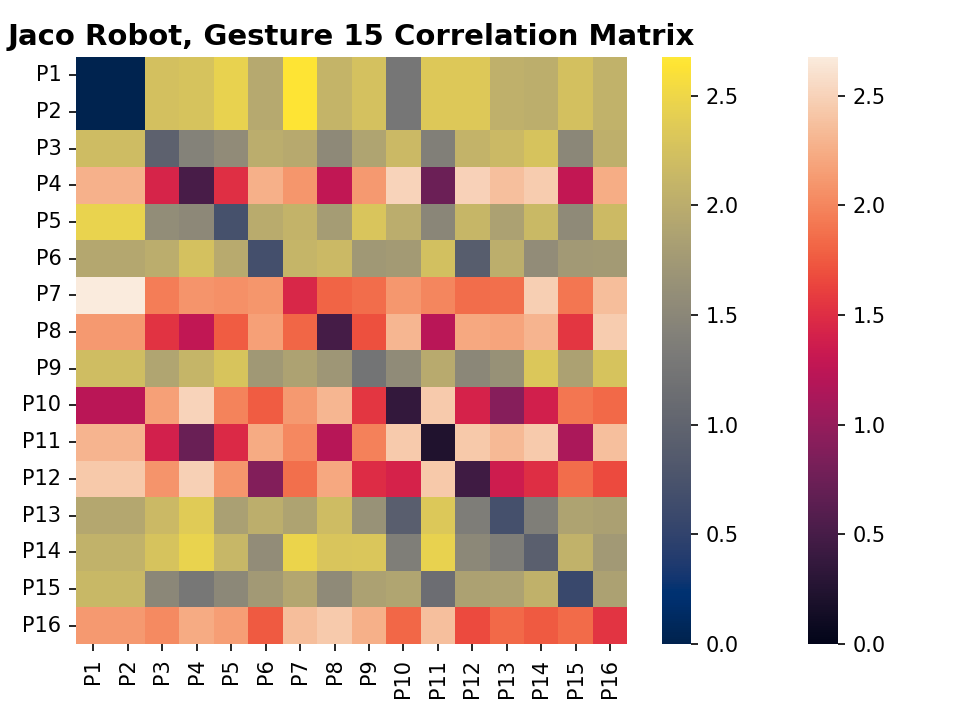

Getting metrics for Participants 1 and 1: 
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Gesture 15: Failed to get metrics for participant 1 demo 1, 1 demo 5.
 Retrying...
Unable to compare participants 1 demo 1 and 1 demo 5
Gesture 15: Failed to get metrics for participant 1 demo 2, 1 demo 5.
 Ret

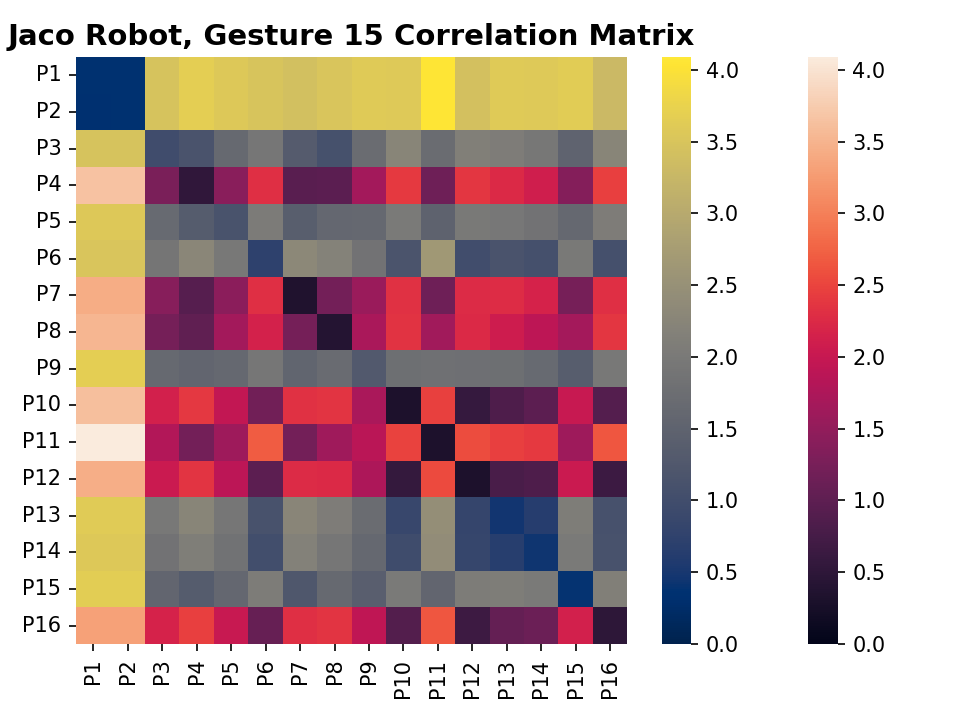

In [3]:
##Batch generation of Cross-correlation matrixes
%matplotlib widget
robot_name = "Reachy"
followup=False
demo_max = 5
alignment = Alignment.SpatioTemporal

# for gesture in range(1,16):    
#     plt.close("all")
#     correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
# #     np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
# #     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
# #     data = np.load(filename)
# #     correlation_array = data['correlation_array']
# #     hand_array = data['hand_array']
# #     plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

# robot_name = "j2s6s300"
# for gesture in range(15,16):    
#     plt.close("all")
#     correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
#     np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
#     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
#     data = np.load(filename)
#     correlation_array = data['correlation_array']
#     hand_array = data['hand_array']
#     plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

# alignment = Alignment.Spatial
# robot_name = "Reachy"
# for gesture in range(1,16):    
#     plt.close("all")
#     correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
#     np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
#     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
#     data = np.load(filename)
#     correlation_array = data['correlation_array']
#     hand_array = data['hand_array']
#     plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

# robot_name = "j2s6s300"
# for gesture in range(15,16):    
#     plt.close("all")
#     correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
#     np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
#     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
#     data = np.load(filename)
#     correlation_array = data['correlation_array']
#     hand_array = data['hand_array']
#     plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

alignment = Alignment.Temporal
robot_name = "Reachy"
for gesture in range(1,16):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

# robot_name = "j2s6s300"
# for gesture in range(15,16):    
#     plt.close("all")
#     correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
#     np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
#     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
#     data = np.load(filename)
#     correlation_array = data['correlation_array']
#     hand_array = data['hand_array']
#     plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)


In [ ]:
## Comparison between RH and robot end-eff
# (We'll want comparisons between the person's different demos, and the end-eff and the lh, also)

# robot_name='j2s6s300'
robot_name='Reachy'

followup = False

if followup:
    PID_max = 9
    gesture_max = 6
else: 
    PID_max = 16
    gesture_max = 15

for singlePIDval in range(1,PID_max+1):
    for gesture_num in range(1,gesture_max+1):
        end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)

        demo_max=5
        end_eff, camera, rh, lh, joints = segment_by_demo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
        # for i in range(0,5):
        #     plot_raw_data(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])

        for demo_num in range(0,5):
            end_eff_traj = get_evo_trajectory(end_eff[i])
            right_hand_traj = get_evo_trajectory(rh[i])   

            end_eff_traj, right_hand_traj = evo_sync(end_eff_traj, right_hand_traj)

            metric = evaluate_ape(end_eff_traj, right_hand_traj)
            print(metric.get_all_statistics()) # Not aligned statistics
            
            right_hand_traj = align(right_hand_traj, end_eff_traj)

            end_eff_aligned = convert_evo_to_np(end_eff_traj, end_eff[i].shape)
            # print(end_eff_aligned.shape)
            
            rh_aligned = convert_evo_to_np(right_hand_traj, rh[i].shape)
            # print(rh_aligned.shape)

            metric = evaluate_ape(end_eff_traj, right_hand_traj)
            metric.get_all_statistics() #Aligned statistics

In [ ]:
## Batch heatmap processing for follow-up study
%matplotlib widget
robot_name = "Reachy"
followup=True
demo_max = 5
alignment = Alignment.SpatioTemporal

PID_max, gesture_max = study_range_vals(followup)

for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

robot_name = "j2s6s300"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

alignment = Alignment.Spatial
robot_name = "Reachy"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

robot_name = "j2s6s300"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

alignment = Alignment.Temporal
robot_name = "Reachy"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

robot_name = "j2s6s300"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)


In [ ]:
## Batch hand/endeff similarity comparison

%matplotlib widget
robot_name = "Reachy"
followup=False
demo_max = 5
alignment = Alignment.SpatioTemporal

plt.close("all")
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)

plt.close("all")
alignment = Alignment.Spatial
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)

plt.close("all")
alignment = Alignment.Temporal
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)


robot_name = "j2s6s300"
alignment = Alignment.SpatioTemporal
plt.close("all")
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)

plt.close("all")
alignment = Alignment.Spatial
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)

plt.close("all")
alignment = Alignment.Temporal
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)


In [11]:
## Batch processing for follow-up users vs original participants

# Return participants: original #, followup #
participant_matching_list = [[11,2],[6,5],[13,7],[1,8],[10,9]]
new_participants = [1,3,4,6]

gesture_matching_list_Reachy=[[2,6],[3,5],[10,4],[11,3],[12,2],[15,1]]
gesture_list_Reachy_original=[15,12,11,10,3,2]
gesture_matching_list_jaco=[[1,6],[4,5],[10,4],[11,3],[12,2],[15,1]]
gesture_list_Jaco_original=[15,12,11,10,4,1]

# Sort them in the order of returning, new:
followup_participant_list = [8,5,9,2,7,1,3,4,6]

##Batch generation of Cross-correlation matrixes
%matplotlib widget
robot_name = "Reachy"
followup=False

PIDmax, gesture_max = study_range_vals(followup=True)

demo_max = 5
alignment = Alignment.SpatioTemporal



for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment,isfollowup2=True)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_w_FollowUpPs_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_w_FollowUpPs_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array, followup_participant_override=True)

robot_name = "j2s6s300"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment,isfollowup2=True)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_w_FollowUpPs_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_w_FollowUpPs_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array, followup_participant_override=True)

alignment = Alignment.Spatial
robot_name = "Reachy"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment,isfollowup2=True)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_w_FollowUpPs_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_w_FollowUpPs_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array, followup_participant_override=True)

robot_name = "j2s6s300"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment,isfollowup2=True)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_w_FollowUpPs_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_w_FollowUpPs_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array, followup_participant_override=True)

alignment = Alignment.Temporal
robot_name = "Reachy"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment,isfollowup2=True)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_w_FollowUpPs_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_w_FollowUpPs_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array, followup_participant_override=True)

robot_name = "j2s6s300"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment,isfollowup2=True)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_w_FollowUpPs_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_w_FollowUpPs_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array, followup_participant_override=True)


9

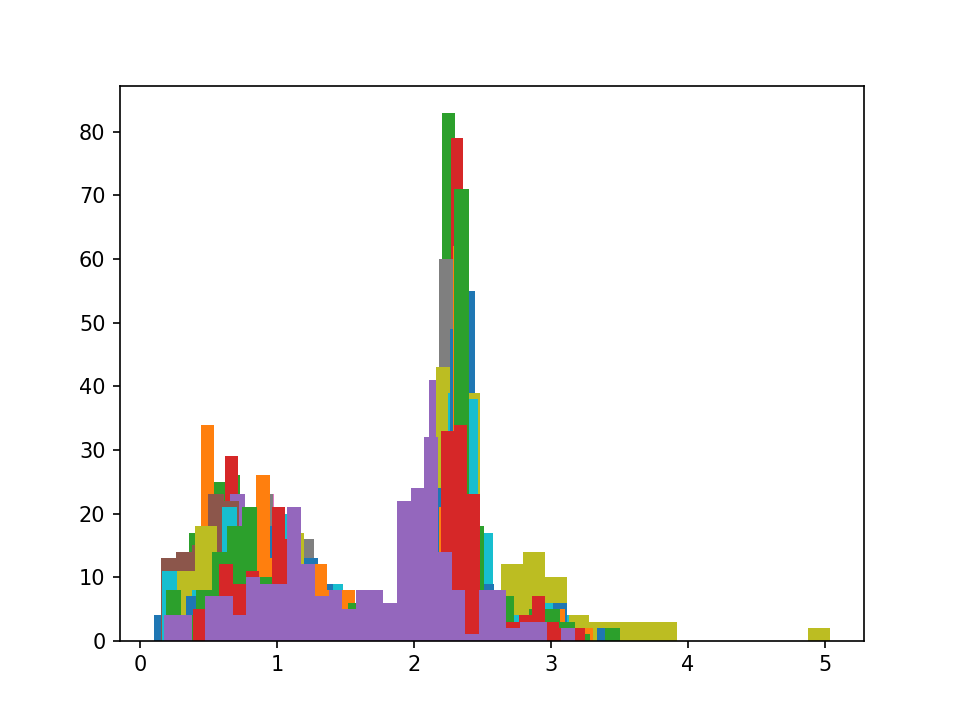

In [36]:
## Generate histogram bins for similarity; figure out the threshold value

%matplotlib widget
robot_name = "Reachy"
# robot_name = "j2s6s300"
followup=False
demo_max = 5
alignment = Alignment.Temporal

PID_max, gesture_max = study_range_vals(followup)

gesture_start = 1
gesture_end = gesture_max

plt.close("all")

# for gesture in range(gesture_start,gesture_end+1):
#     # plt.close("all")
#     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
#     data = np.load(filename)
#     correlation_array = data['correlation_array']
#     hand_array = data['hand_array']
#     plt.hist(correlation_array.flatten(),bins=30)
# plt.show()
# plt.title(robot_name+" Similarity Histogram, Gestures "+str(gesture_start)+"-"+str(gesture_end))
# plt.savefig(robot_name+"_threshold_similarity_gestures_"+str(gesture_start)+"_"+str(gesture_end)+".png")
    
for gesture in range(gesture_start,gesture_end+1):
    # plt.close("all")
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    # hand_array = data['heat_map']
    plt.hist(correlation_array.flatten(),bins=30)
plt.show()
# plt.title(robot_name+" EEFF Similarity Histogram, Gestures "+str(gesture_start)+"-"+str(gesture_end))
# plt.savefig(robot_name+"_eeff_threshold_similarity_gestures_"+str(gesture_start)+"_"+str(gesture_end)+".png")

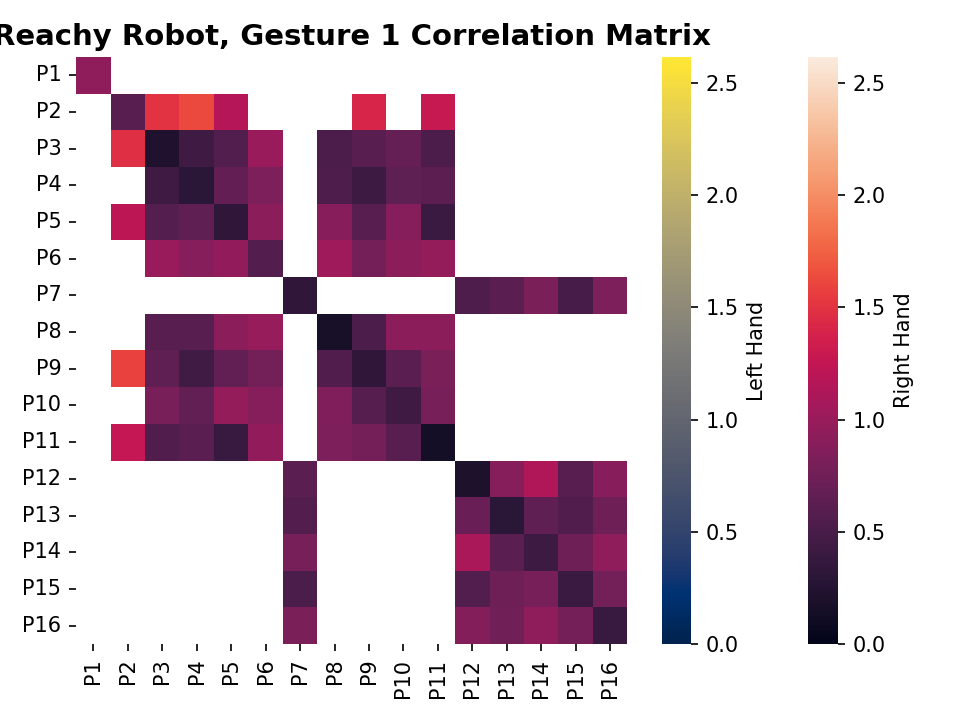

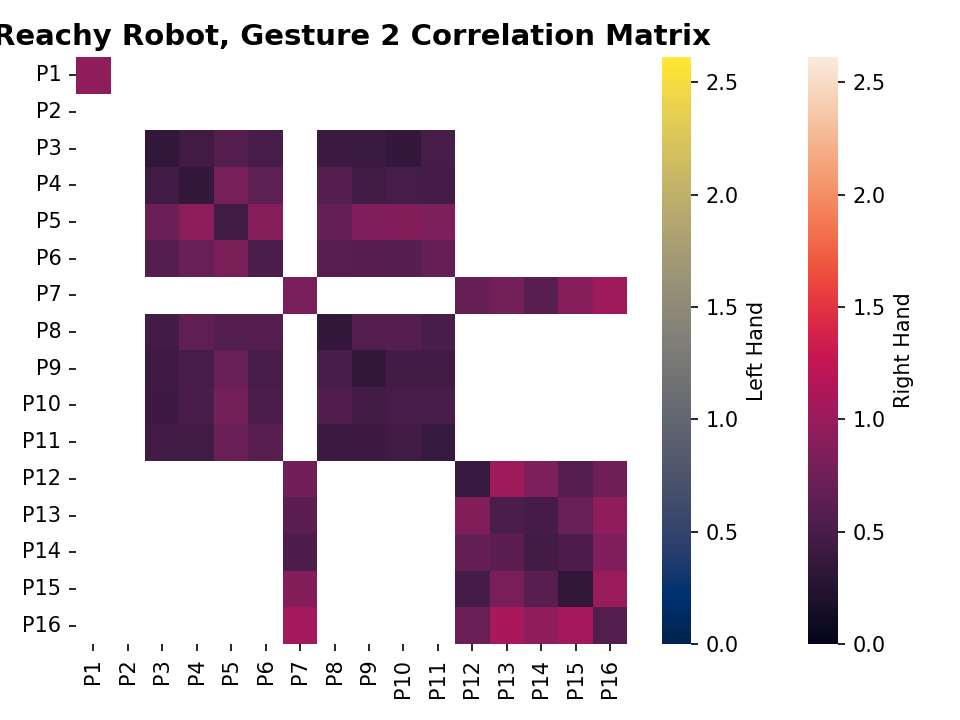

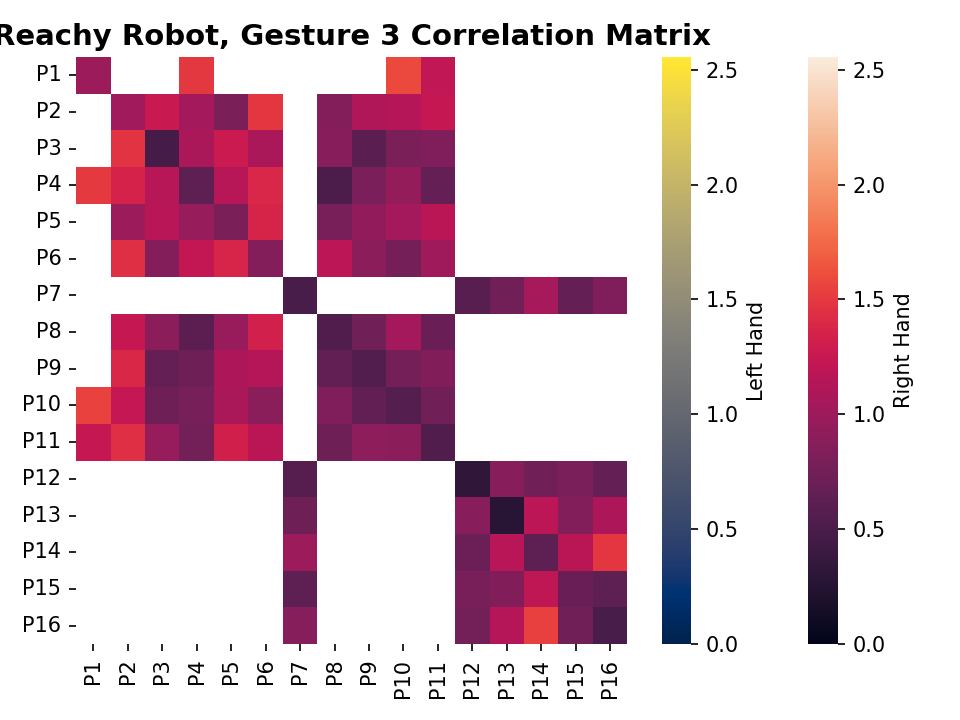

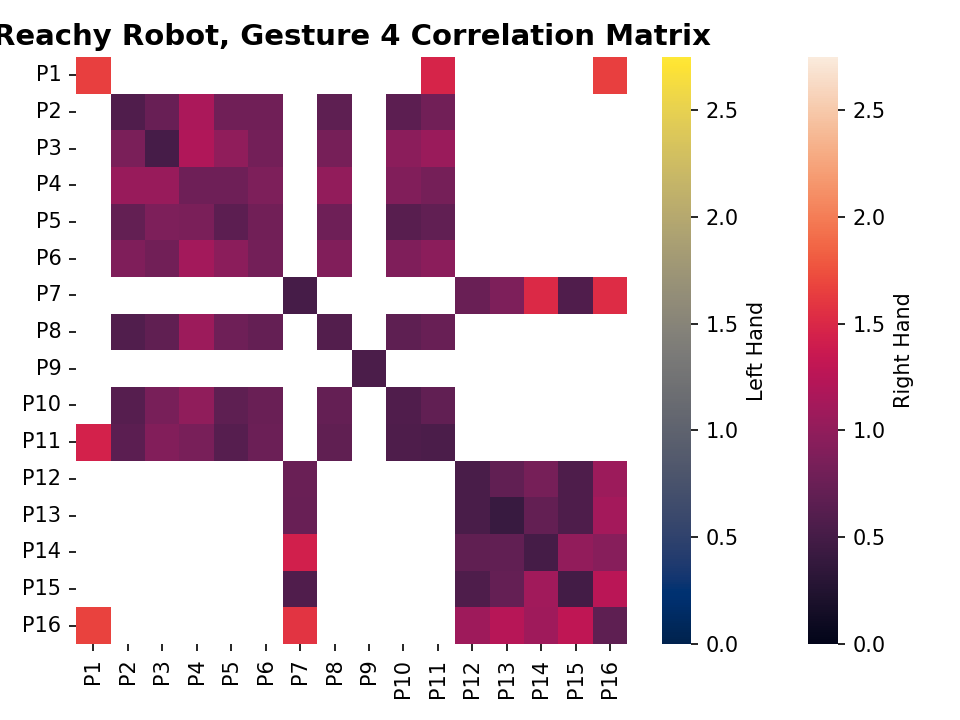

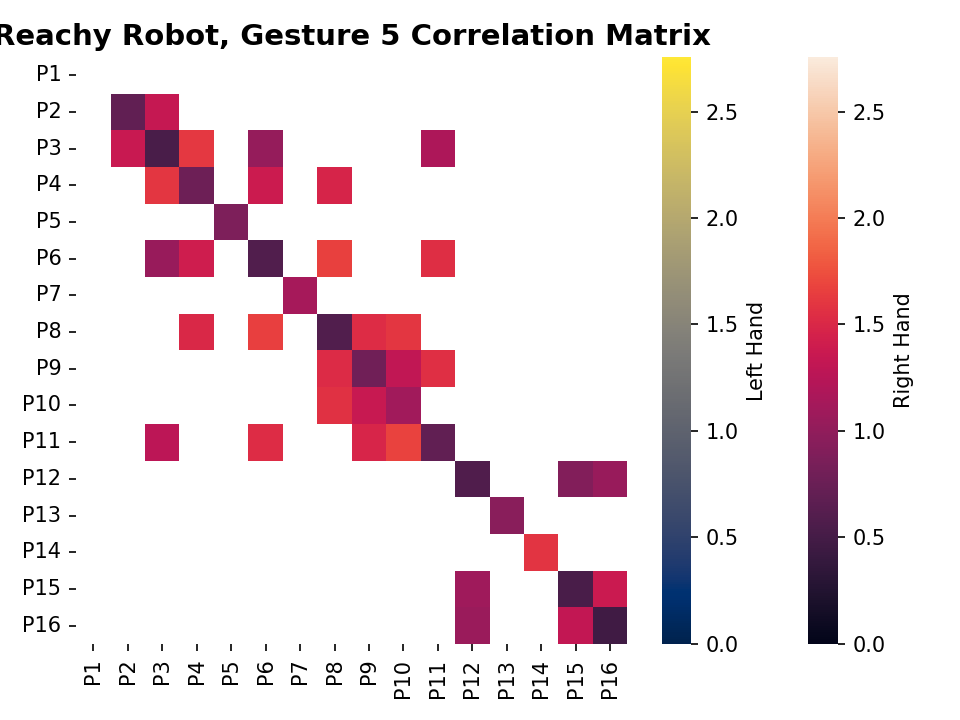

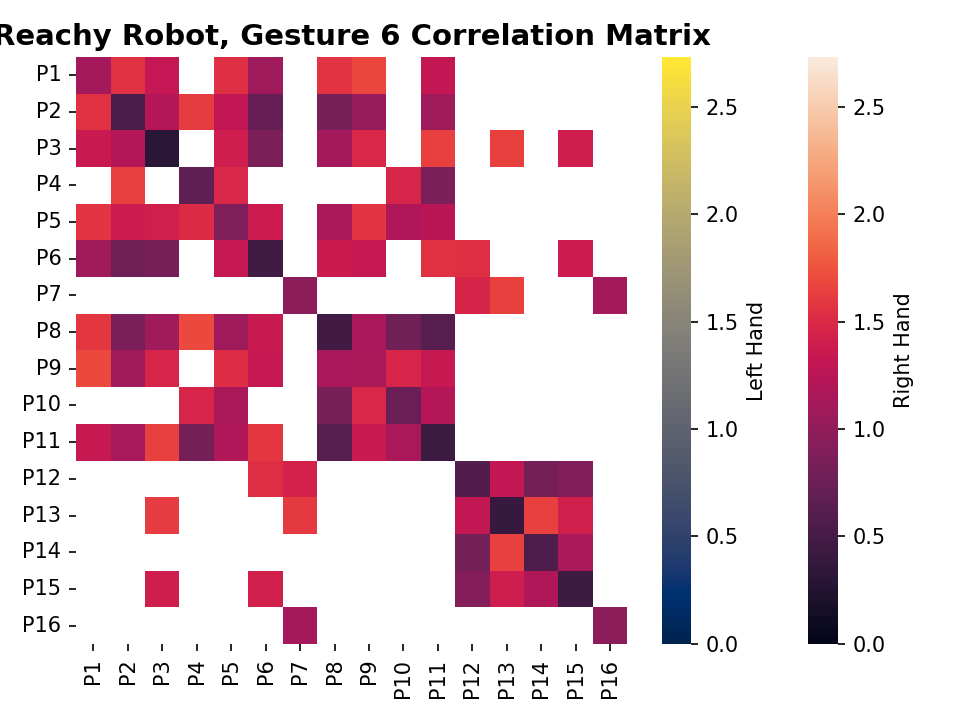

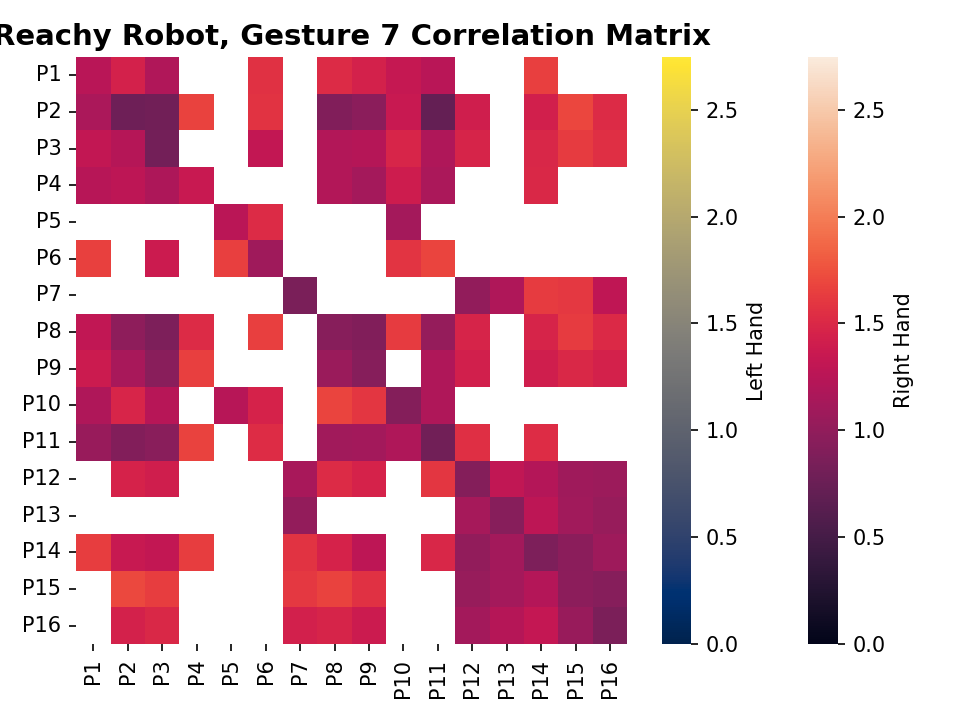

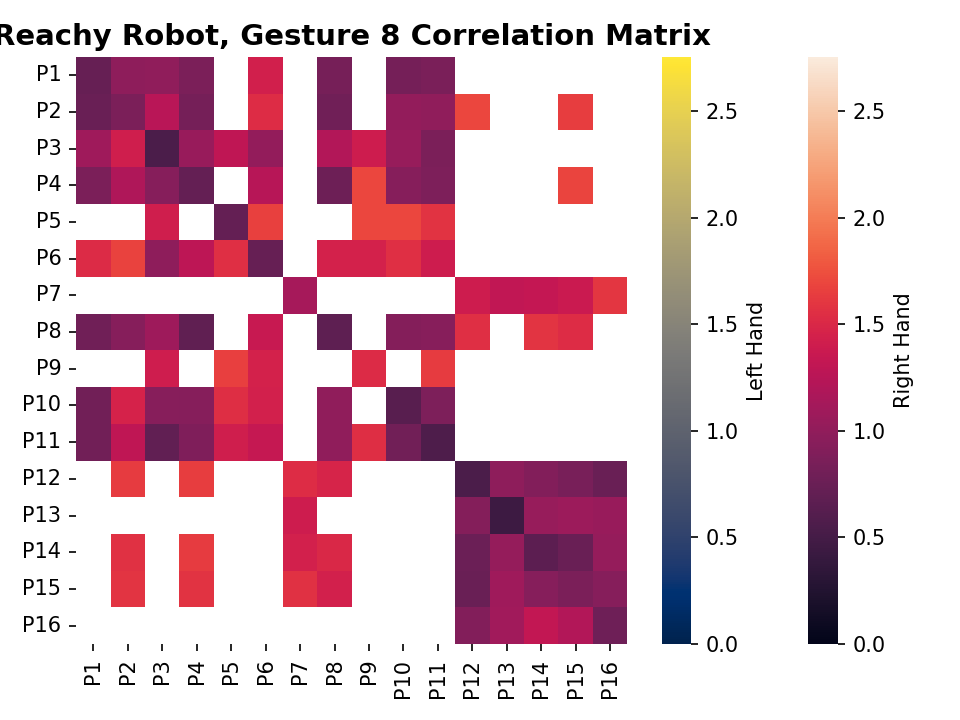

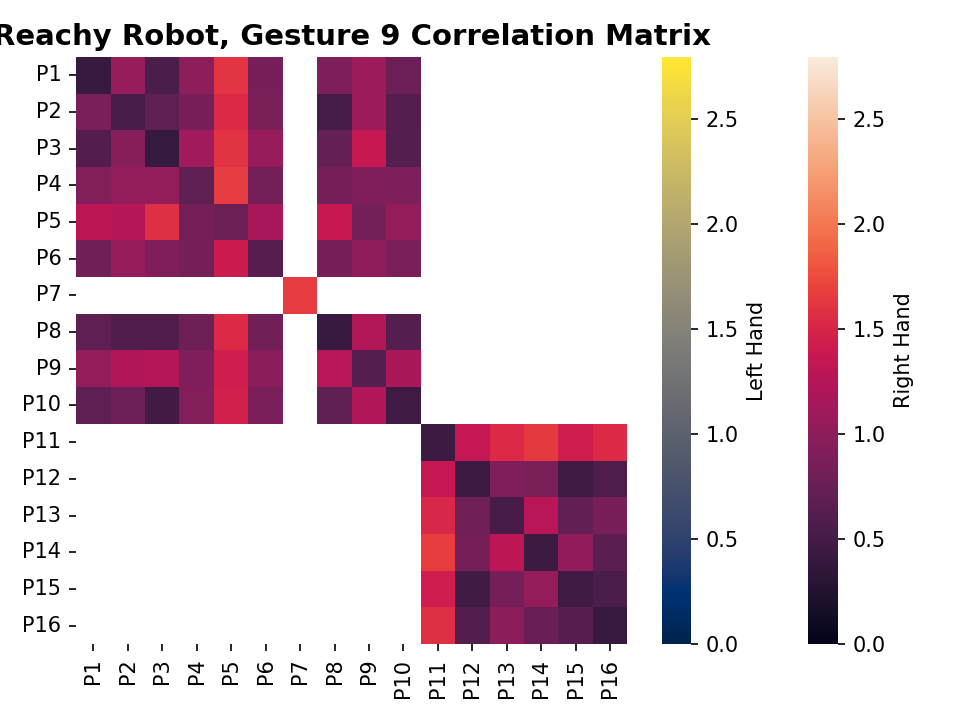

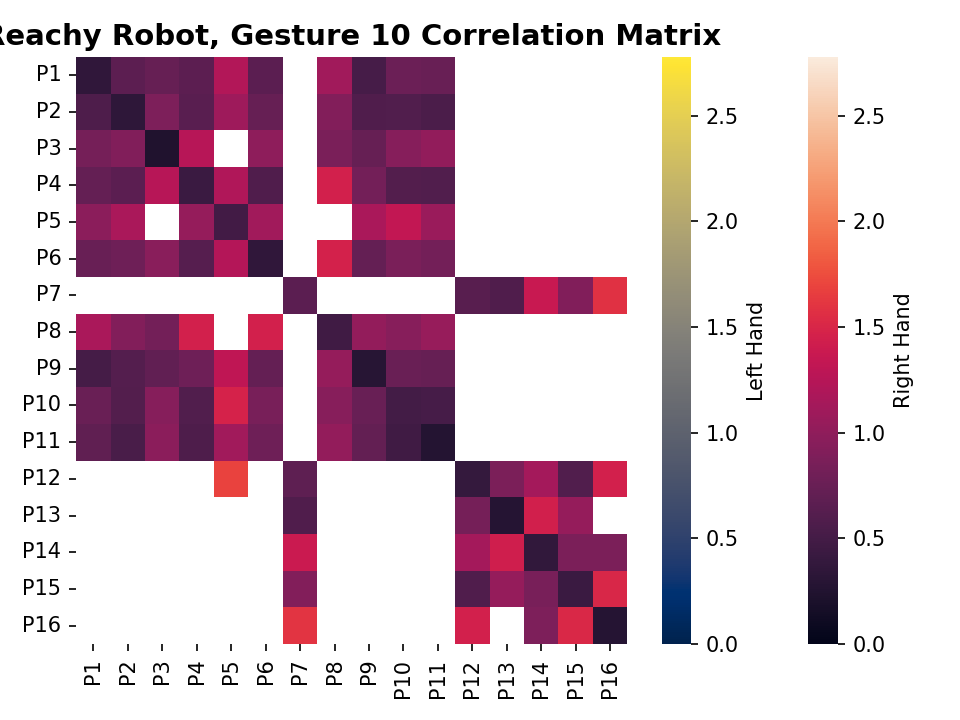

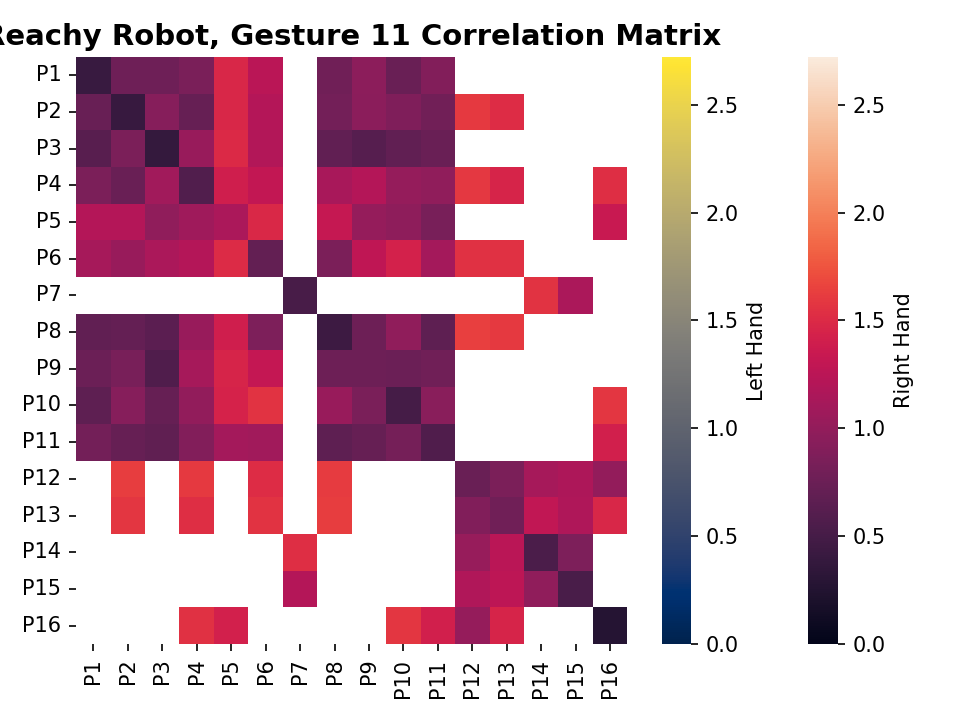

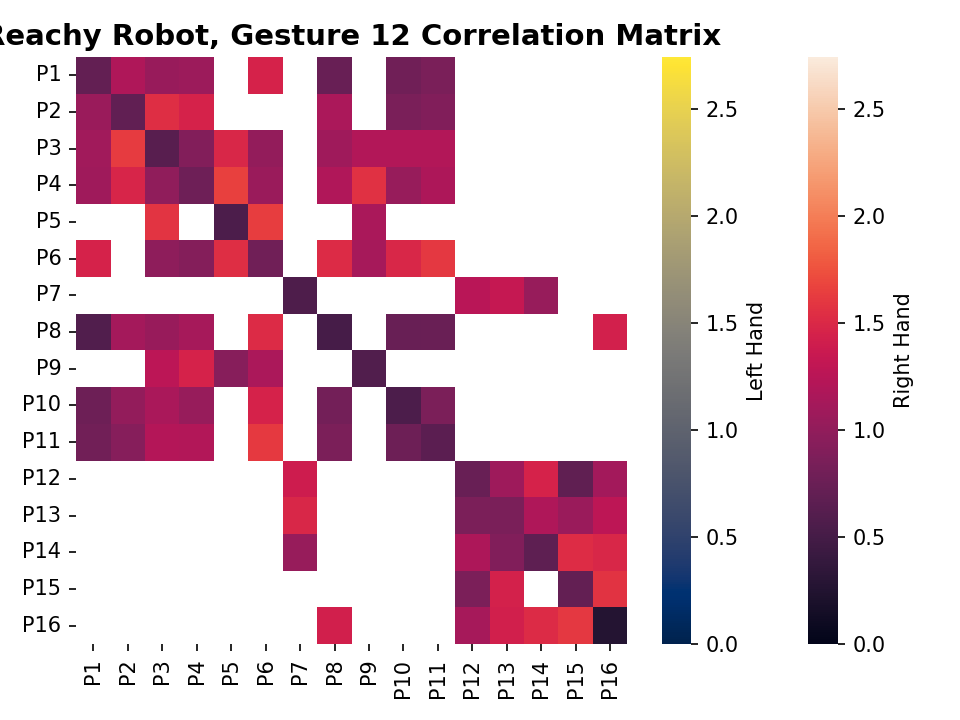

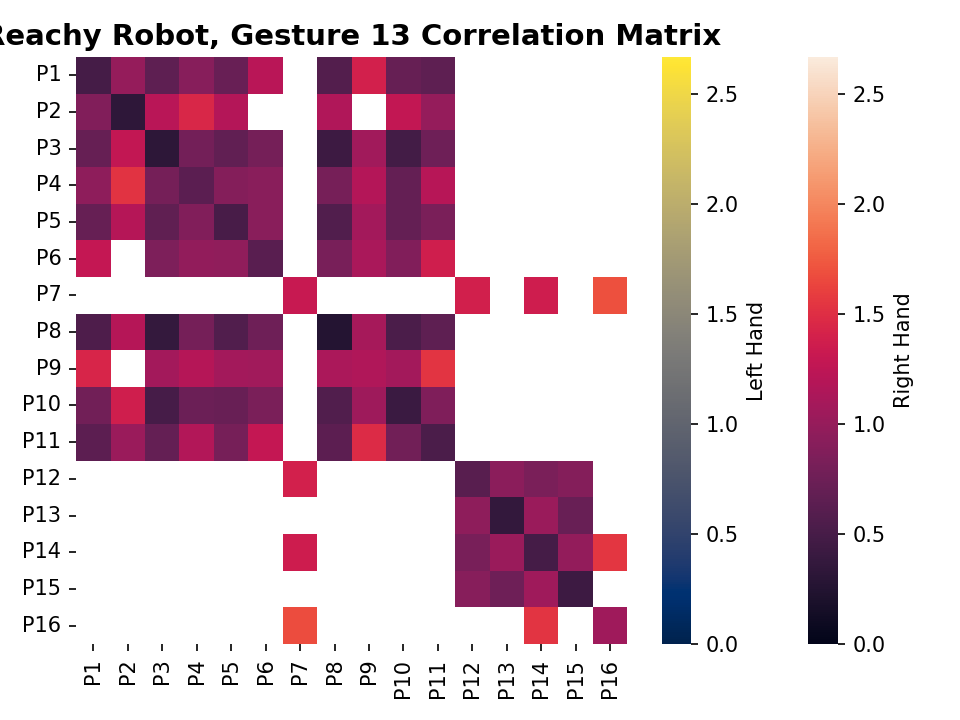

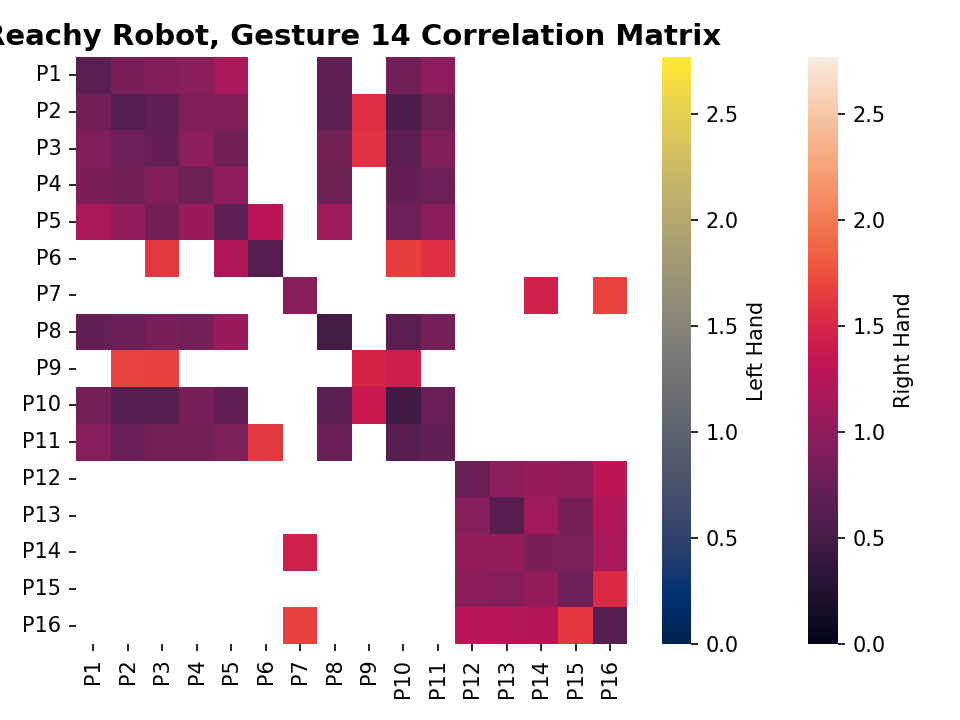

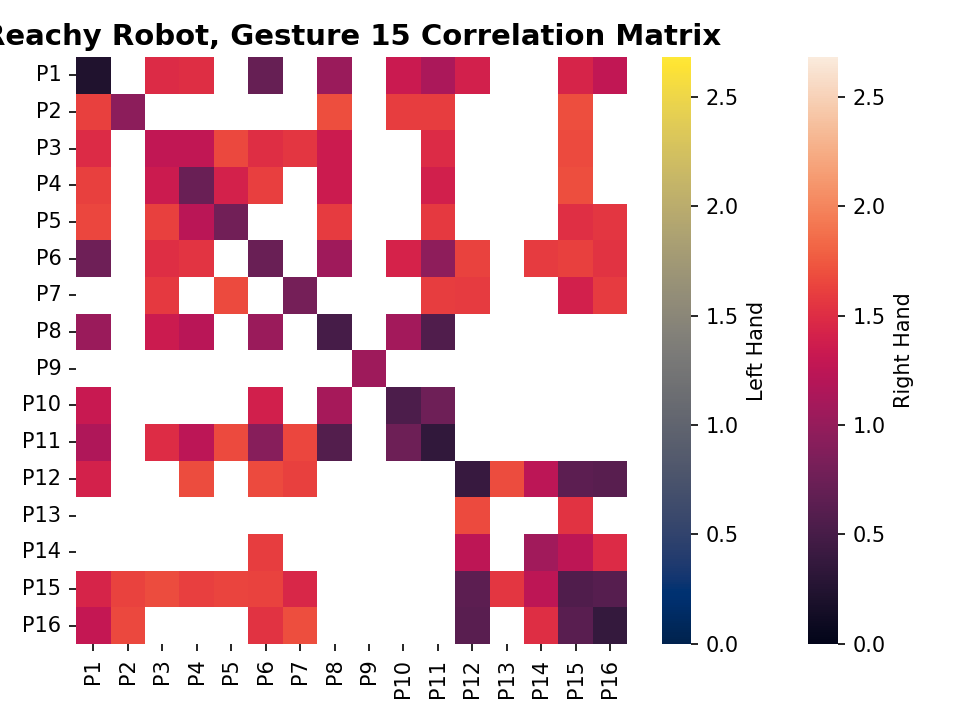

No such comm: d90edffac62f4f54b02713ae8a81b446
No such comm: d90edffac62f4f54b02713ae8a81b446
No such comm: 35920f66a8db406c9e8007132364a44c
No such comm: 35920f66a8db406c9e8007132364a44c
No such comm: 35920f66a8db406c9e8007132364a44c
No such comm: 35920f66a8db406c9e8007132364a44c
No such comm: 35920f66a8db406c9e8007132364a44c
No such comm: e6392de6611841a9bb181ae231ae3a11
No such comm: e6392de6611841a9bb181ae231ae3a11
No such comm: e6392de6611841a9bb181ae231ae3a11
No such comm: e6392de6611841a9bb181ae231ae3a11
No such comm: e6392de6611841a9bb181ae231ae3a11
No such comm: 7c7bf1fb50364ed88de02b66153e63aa
No such comm: 7c7bf1fb50364ed88de02b66153e63aa
No such comm: 7c7bf1fb50364ed88de02b66153e63aa
No such comm: 7c7bf1fb50364ed88de02b66153e63aa
No such comm: 7c7bf1fb50364ed88de02b66153e63aa
No such comm: 35133ca8e02b481d8fd0ca9302f146e3
No such comm: 35133ca8e02b481d8fd0ca9302f146e3
No such comm: 35133ca8e02b481d8fd0ca9302f146e3
No such comm: 35133ca8e02b481d8fd0ca9302f146e3
No such comm:

In [ ]:
%matplotlib widget
robot_name = "Reachy"
# robot_name = "j2s6s300"
followup=False
demo_max = 5
alignment = Alignment.SpatioTemporal

PID_max, gesture_max = study_range_vals(followup)

gesture_start = 1
gesture_end = 15

threshold=1.7

for gesture in range(gesture_start,gesture_end+1):
    plt.close("all")
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array, threshold=threshold)

# for gesture in range(gesture_start,gesture_end+1):
#     plt.close("all")
#     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
#     data = np.load(filename)
#     correlation_array = data['correlation_array']
#     clusters=np.array([])
#     for i in range(0,correlation_array.shape[0]):
#         for j in range(0,correlation_array.shape[1]):
#             if correlation_array[i,j]<=threshold:
#                 if clusters.append([i,j])


In [3]:
##Clustering function (now in nah.utils)
from sklearn.cluster import AgglomerativeClustering

%matplotlib widget
# robot_name = "Reachy"
robot_name = "j2s6s300"
followup=False
demo_max = 5
alignment = Alignment.SpatioTemporal

PID_max, gesture_max = study_range_vals(followup)

gesture_start = 1
gesture_end = gesture_max

threshold=1.7
gesture=3

clustering_vals_original_Reachy=np.zeros([PID_max,PID_max])

# for gesture in range(gesture_start,gesture_end+1):

filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
data = np.load(filename)
correlation_array = data['correlation_array']
# hand_array = data['hand_array']
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.7, compute_full_tree=True, linkage='complete').fit(correlation_array)
clustering
clustering_vals_original_Reachy[gesture-1]=clustering.labels_
print(clustering.labels_)

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.7, compute_full_tree=True, linkage='average').fit(correlation_array)
clustering
clustering_vals_original_Reachy[gesture-1]=clustering.labels_

print(clustering.labels_)

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.7, compute_full_tree=True, linkage='ward').fit(correlation_array)
clustering
clustering_vals_original_Reachy[gesture-1]=clustering.labels_

print(clustering.labels_)

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.7, compute_full_tree=True, linkage='single').fit(correlation_array)
clustering
clustering_vals_original_Reachy[gesture-1]=clustering.labels_

print(clustering.labels_)


[2 2 1 4 2 1 3 1 1 0 1 1 0 3 4 0]
[3 3 0 0 3 0 2 0 0 1 0 0 1 2 0 1]
[2 2 1 4 2 1 3 1 1 0 1 1 0 3 4 0]
[1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0]


In [25]:
## Batch clustering
%matplotlib widget
robot_name = "Reachy"
followup=False
demo_max = 5
alignment = Alignment.Temporal
threshold=1.5
linkage='single'

plt.close("all")
PID_max,gesture_max=study_range_vals(followup)

Reachy_cluster_vals = cluster(robot_name, followup, alignment, threshold=threshold, linkage=linkage,eeff=False)
# followup=True
# Reachy_cluster_vals_w_followup = cluster(robot_name, followup, alignment, threshold=threshold, linkage=linkage)
robot_name = "j2s6s300"
followup=False
Jaco_cluster_vals = cluster(robot_name, followup, alignment, threshold=threshold, linkage=linkage, eeff=False)
# followup=True
# Jaco_cluster_vals_w_followup = cluster(robot_name, followup, alignment, threshold=threshold, linkage=linkage)

# print(Reachy_cluster_vals)
# print(Jaco_cluster_vals)

In [41]:
# Need to process the rows so that similar groupings don't alternate which colors are dark and light

# for i in range(0,cluster_vals.shape[0]):
#     compare_rows(cluster_vals, i,i+1)
#     print(i)

def compare_rows(row_1, row_2):
    unique_row_2_vals = np.unique(row_2)
    # We want to maximize the number of elements that match from one row to the next
    for i in range(0,unique_row_2_vals.shape[0]-1):
        for j in range(0,unique_row_2_vals.shape[0]):
            temp_row = switch_elements(row_2, unique_row_2_vals[i], unique_row_2_vals[j])
            if count_matched_elements(row_1, temp_row)>count_matched_elements(row_1, row_2):
                row_2 = np.copy(temp_row)
    return row_2
    

def count_matched_elements(row_1, row_2):
    matches = 0
    for i in range(0,row_1.shape[0]):
        if row_1[i]==row_2[i]:
            matches += 1
    # print(matches)
    return matches

def switch_elements(row_1, val1, val2):
    # Find all occurances of a value in row 1
    row_swap_indices_1 = np.where(row_1==val1)
    row_swap_indices_2 = np.where(row_1==val2)
    new_row = np.copy(row_1)
    for i in row_swap_indices_1:
        new_row[i] = val2
    for i in row_swap_indices_2:
        new_row[i] = val1
    
    # print("New row:"+str(new_row)+"\nOld row: "+str(row_1))
    return new_row

def organize_cluster_graph(cluster_array):
    for i in range(0,cluster_array.shape[0]-1):
        cluster_array[i+1]=compare_rows(cluster_array[i],cluster_array[i+1])
    return cluster_array

print(Reachy_cluster_vals)
print(organize_cluster_graph(Reachy_cluster_vals))

[[3. 2. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [3. 2. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [2. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [3. 1. 1. 1. 1. 1. 0. 1. 2. 1. 1. 0. 0. 0. 0. 0.]
 [0. 4. 0. 0. 2. 0. 3. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 3. 1. 1. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 1. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 1. 2. 0. 2. 2. 2. 2. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 3. 3. 0. 0. 2.]
 [1. 1. 1. 1. 2. 1. 0. 1. 2. 1. 1. 0. 0. 0. 0. 3.]
 [0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 1. 1. 1. 2.]
 [2. 2. 2. 2. 2. 0. 3. 2. 0. 2. 2. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 0. 0. 0. 0. 0.]]
[[3. 2. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [3. 2. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [2. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [2. 0. 0. 0. 0. 0. 1. 0. 3. 0. 0. 1. 1. 1. 1. 1.]
 [0. 4. 0. 0. 2. 0. 3. 0. 0. 0

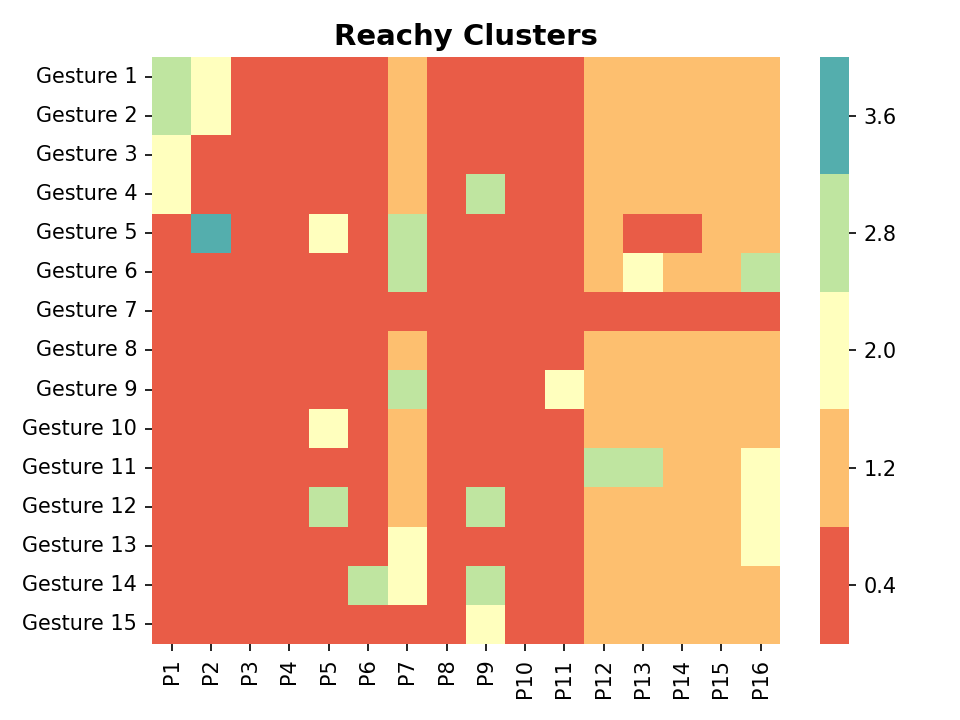

In [62]:



plt.close("all")
robot_name = "Reachy"

if (robot_name == "j2s6s300"):
    robot_name = "Jaco"

col_labels = []
row_labels = []
cluster_vals=Reachy_cluster_vals
num_colors = np.unique(cluster_vals).shape[0]

PID_max,gesture_max=study_range_vals(followup)

for i in range(1, gesture_max + 1):
    row_labels.append("Gesture " + str(i))

for i in range(1, PID_max + 1):
    col_labels.append("P" + str(i))

df = pd.DataFrame(cluster_vals, columns=col_labels)

df.index = row_labels

# ax = sns.heatmap(heatmap_array,
#                     cmap=cmap,
#                     vmin=0,
#                     vmax=np.max(heatmap_array),
#                     mask=threshold_mask,
#                     cbar_kws={'label': 'Right Hand'})

cmap = sns.color_palette("Spectral", num_colors)

ax = sns.heatmap(df,
            # cmap='cividis',
            cmap=cmap,
            # mask=cluster_vals,
            vmin=0,
            vmax=np.max(cluster_vals))


# Get the colorbar object from the Seaborn heatmap
colorbar = ax.collections[0].colorbar
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (num_colors) + r * i / (num_colors) for i in range(num_colors)])
# colorbar.set_ticklabels(list(vmap.values()))

title = robot_name + " Clusters"
if followup:
    title += ",\n Follow-up Study"

ax.set_title(title, fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()
figname = robot_name + '_clusters_' + str(alignment)
if followup:
    figname += '_FollowUpStudy'
figname += '.png'
plt.savefig(figname)



[[3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


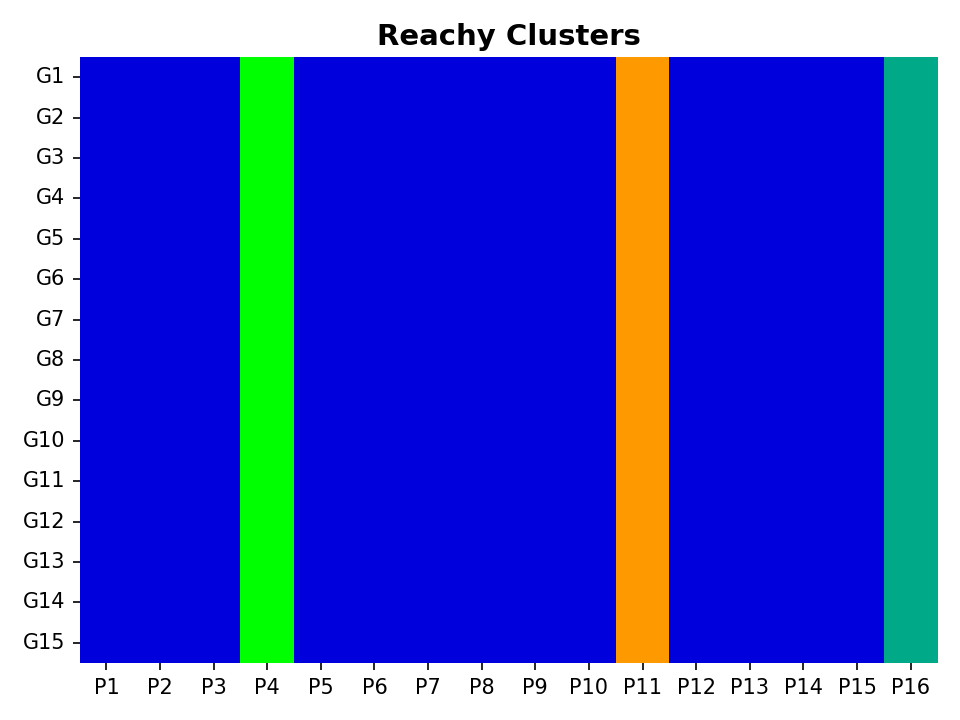

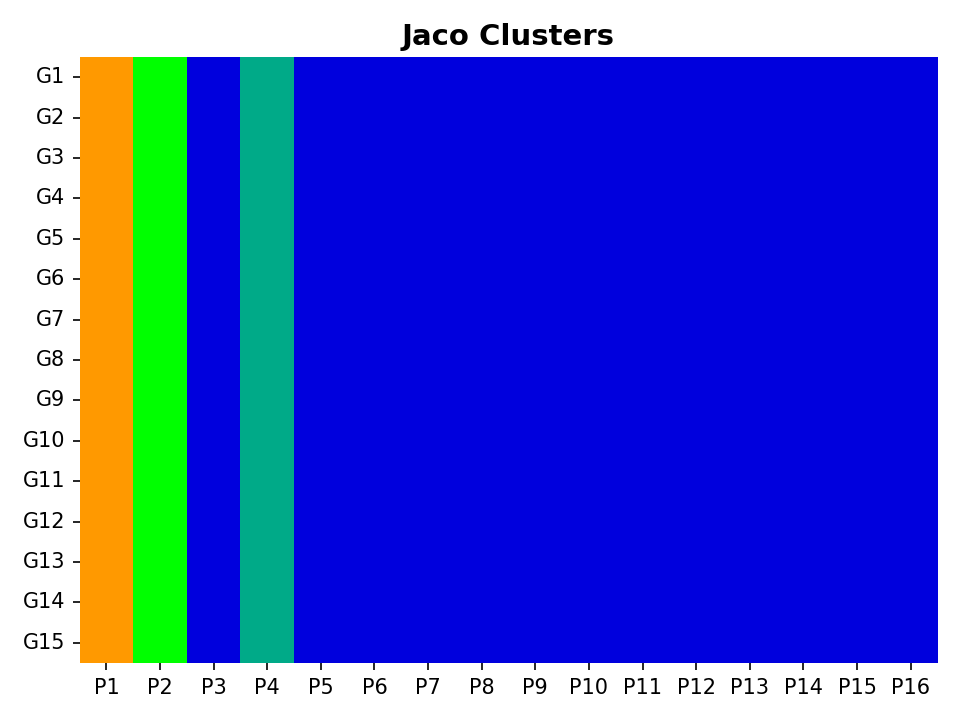

No such comm: 2007b926ba664f91aebc64cf5b747daa


In [26]:
## Print cluster groupings
# print(Reachy_cluster_vals)
# print(Reachy_cluster_vals_w_followup)
print(Jaco_cluster_vals)
# print(Jaco_cluster_vals_w_followup)

# organize_cluster_graph(Reachy_cluster_vals)
# organize_cluster_graph(Reachy_cluster_vals_w_followup)
organize_cluster_graph(Jaco_cluster_vals)
# organize_cluster_graph(Jaco_cluster_vals_w_followup)

robot_name = "Reachy"
followup=False
demo_max = 5
# alignment = Alignment.SpatioTemporal
threshold=1.7
linkage='single'

plot_clusters(robot_name, followup, Reachy_cluster_vals, alignment,eeff=True)
# followup=True
# plot_clusters(robot_name, followup, Reachy_cluster_vals_w_followup, alignment)
robot_name="j2s6s300"
followup=False
plot_clusters(robot_name, followup, Jaco_cluster_vals, alignment,eeff=True)
followup=True
# plot_clusters(robot_name, followup, Jaco_cluster_vals_w_followup, alignment)

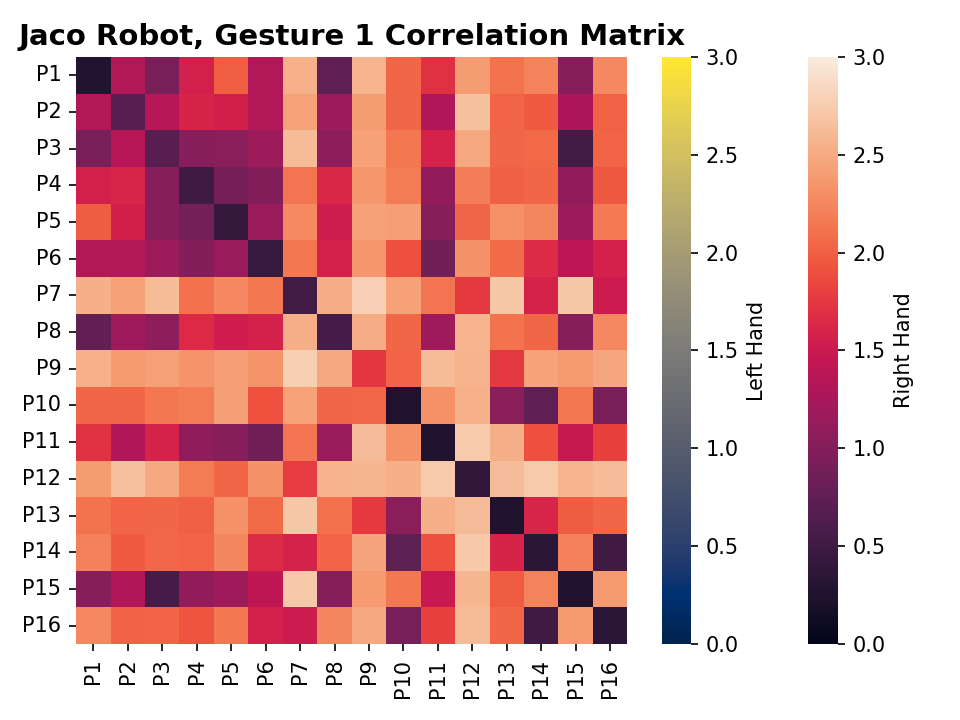

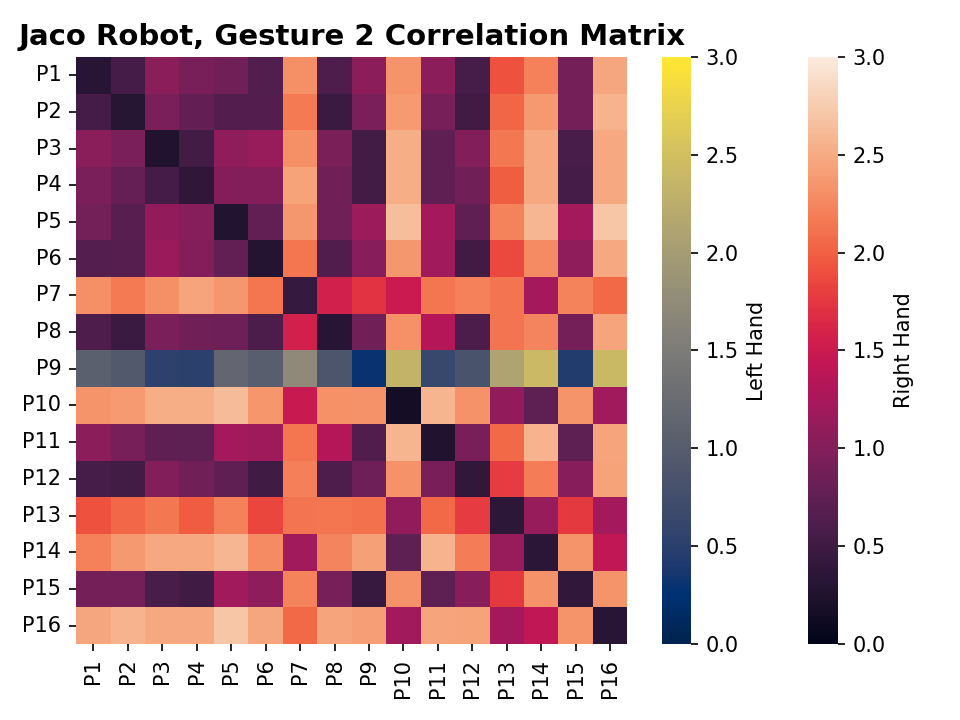

No such comm: 24527dcbe44641688ec489cdd2a8a212


In [6]:
##From npzs generate new correlation plots:

##Batch generation of Cross-correlation matrixes
%matplotlib widget
robot_name = "Reachy"
followup=False
demo_max = 5
alignment = Alignment.Spatial

PID_max, gesture_max=study_range_vals(followup)
gesture_start=1
gesture_end=2

# for gesture in range(gesture_start,gesture_end+1):    
#     plt.close("all")
#     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
#     data = np.load(filename)
#     correlation_array = data['correlation_array']
#     hand_array = data['hand_array']
#     plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

robot_name = "j2s6s300"
for gesture in range(gesture_start, gesture_end+1):    
    plt.close("all")
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

In [16]:
out = np.load("Reachy_eeff_hand_similarity_matrix_Alignment.Temporal.npz")

In [17]:
out['heat_map']

array([[2.60596869, 2.42021733, 2.34970448, 2.59400622, 2.52032796,
        2.32290815, 2.75192471, 2.63046603, 2.68621361, 2.59062522,
        2.64876853, 2.67093313, 2.54761932, 2.65605529, 2.66872875],
       [2.27429753, 2.18810744, 2.10376238, 2.28731603, 2.09464551,
        2.08278845, 2.34461417, 2.36970979, 2.23965449, 2.22051077,
        2.22351439, 2.28842683, 2.05031457, 2.18817456, 2.28082003],
       [2.13595947, 2.13163612, 2.39486699, 2.64134256, 2.48100428,
        2.47600854, 2.91883883, 2.8636503 , 2.86973418, 2.72451739,
        2.73694698, 2.98611849, 2.40091127, 2.50613418, 2.44447383],
       [2.43706964, 2.36452153, 2.33688906, 2.68497662, 2.43307509,
        2.51560554, 3.08184873, 3.08573707, 3.13110612, 3.13463724,
        3.33373256, 3.43213872, 3.45965685, 3.58666714, 3.72352236],
       [2.25509694, 2.09533974, 2.07924573, 2.28076333, 2.13383145,
        2.15657682, 2.42620478, 2.22375529, 2.30577378, 2.09151116,
        2.10915423, 2.46642624, 2.19261354, 